In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import warnings
import logging
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [15]:
!apt-get -y install fonts-noto-cjk > /dev/null
!fc-cache -fv > /dev/null
!rm -rf ~/.cache/matplotlib

font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
fontprop = fm.FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = fontprop.get_name()
plt.rcParams['axes.unicode_minus'] = False

In [16]:
# 데이터 불러오기
train_src = '/content/drive/MyDrive/Colab Notebooks/패턴인식/train.csv'
train_df = pd.read_csv(train_src)
X = train_df.drop(['id','shares','y'], axis=1)
y = train_df['y']
df = train_df.copy() # 원본 보존
'''df_missing_indicators # Missing Indicator 추가한 df (결측 여부와 성능 관계 확인)'''

'df_missing_indicators # Missing Indicator 추가한 df (결측 여부와 성능 관계 확인)'

In [17]:
train_df.head()

,id,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,data_channel,weekday,shares,y
0,17335,9.0,409.0,0.501326,1.0,0.587361,23.0,2.0,11.0,0.0,...,-0.1875,-0.1,0.50,0.500,0.00,0.500,Lifestyle,NaN,801,0
1,21242,10.0,317.0,0.725086,1.0,0.830097,6.0,3.0,NaN,21.0,...,-0.6000,NaN,0.00,0.000,0.50,0.000,Lifestyle,Tuesday,426,0
2,9448,11.0,447.0,0.584091,1.0,0.730104,NaN,1.0,1.0,1.0,...,-0.5000,-0.1,0.75,0.125,0.25,0.125,World,Friday,2400,1
3,36797,13.0,143.0,0.638298,NaN,0.787500,3.0,2.0,NaN,0.0,...,0.0000,0.0,1.00,NaN,0.50,0.500,Social Media,NaN,1100,0
4,29504,17.0,576.0,0.524412,1.0,0.714286,8.0,3.0,NaN,0.0,...,-1.0000,-0.1,0.00,0.000,0.50,0.000,World,Wednesday,1500,1


In [18]:
def resumetable(df):
    print(f'데이터 셋트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['고유값 개수'] = df.nunique().values
    summary['결측값 개수'] = df.isnull().sum().values
    summary['결측 비율(%)'] = df.isnull().mean().values * 100
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values

    return summary

resumetable(train_df)

데이터 셋트 형상: (22200, 49)


,피처,데이터 타입,고유값 개수,결측값 개수,결측 비율(%),첫 번째 값,두 번째 값,세 번째 값
0,id,int64,22200,0,0.000000,17335,21242,9448
1,n_tokens_title,float64,17,2200,9.909910,9.0,10.0,11.0
2,n_tokens_content,float64,2023,2146,9.666667,409.0,317.0,447.0
3,n_unique_tokens,float64,15806,2258,10.171171,0.501326,0.725086,0.584091
4,n_non_stop_words,float64,1301,2183,9.833333,1.0,1.0,1.0
5,n_non_stop_unique_tokens,float64,13993,2256,10.162162,0.587361,0.830097,0.730104
6,num_hrefs,float64,114,2233,10.058559,23.0,6.0,NaN
7,num_self_hrefs,float64,52,2280,10.270270,2.0,3.0,1.0
8,num_imgs,float64,79,2214,9.972973,11.0,NaN,1.0
9,num_videos,float64,47,2294,10.333333,0.0,21.0,1.0


In [19]:
train_df.drop(columns = 'id').describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,y
count,20000.000000,20054.000000,19942.000000,20017.000000,19944.000000,19967.000000,19920.000000,19986.000000,19906.000000,19987.000000,...,20033.000000,19916.000000,19926.000000,19997.000000,19928.000000,19967.000000,19934.000000,19951.000000,22200.000000,22200.000000
mean,10.387150,543.920614,0.530611,0.970175,0.672893,10.840337,3.303263,4.473431,1.248669,4.552209,...,0.755952,-0.259972,-0.523223,-0.107647,0.284772,0.070169,0.342966,0.155305,3459.794865,0.495676
std,2.105585,460.694982,0.138709,0.170108,0.155004,11.024976,3.944523,8.092647,4.087507,0.840299,...,0.248262,0.127974,0.289365,0.096059,0.327151,0.264686,0.188498,0.225603,12767.254516,0.499993
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,22.000000,0.000000
25%,9.000000,246.000000,0.471005,1.000000,0.626836,4.000000,1.000000,1.000000,0.000000,4.479499,...,0.600000,-0.329167,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,948.000000,0.000000
50%,10.000000,409.000000,0.539683,1.000000,0.691228,7.000000,3.000000,1.000000,0.000000,4.665148,...,0.800000,-0.253718,-0.500000,-0.100000,0.144444,0.000000,0.500000,0.000000,1400.000000,0.000000
75%,12.000000,715.750000,0.609865,1.000000,0.754545,14.000000,4.000000,4.000000,1.000000,4.857716,...,1.000000,-0.187500,-0.300000,-0.050000,0.500000,0.138600,0.500000,0.250000,2800.000000,1.000000
max,19.000000,7413.000000,1.000000,1.000000,1.000000,186.000000,116.000000,108.000000,91.000000,8.041534,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000,1.000000


In [20]:
# y분포 확인
train_df['y'].value_counts(normalize=True) # (11196, 11004)

,proportion
y,
0,0.504324
1,0.495676


## 결측치 처리
가장 기본적인 방법으로 먼저 처리했습니다.
- 수치형 변수: 평균으로 대체
- 범주형 변수: 최빈값으로 대체

이후 피처 엔지니어링 단게에서 다양한 기법으로 처리할 수 있습니다.
- 제거: 결측치가 적을 때
- 단순 대체: 빠른 탐색
- 확률적 대체: 분포 왜곡 최소화(분포 보존)
- 다중 대체(MICE): 변수 간 관계 유지
- 모델 기반 대체: 예측 모델 활용
- 그룹별 대체: 그룹 특성 반영

In [21]:
# 수치형/범주형 컬럼 정의
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = ['data_channel', 'weekday']

# # Missing Indicator
# missing_flags = df[num_cols + cat_cols].isnull().astype(int).add_suffix('_was_missing')
# df_missing_indicators = pd.concat([df, missing_flags], axis=1)

# 수치형 결측치 → 평균 대체
num_imputer = SimpleImputer(strategy='mean')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

# 범주형 결측치 → 최빈값 대체
cat_imputer = SimpleImputer(strategy='most_frequent')
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# 확인
print(X[num_cols].isnull().sum())
print(X[cat_cols].isnull().sum())

n_tokens_title                  0
n_tokens_content                0
n_unique_tokens                 0
n_non_stop_words                0
n_non_stop_unique_tokens        0
num_hrefs                       0
num_self_hrefs                  0
num_imgs                        0
num_videos                      0
average_token_length            0
num_keywords                    0
kw_min_min                      0
kw_max_min                      0
kw_avg_min                      0
kw_min_max                      0
kw_max_max                      0
kw_avg_max                      0
kw_min_avg                      0
kw_max_avg                      0
kw_avg_avg                      0
self_reference_min_shares       0
self_reference_max_shares       0
self_reference_avg_sharess      0
LDA_00                          0
LDA_01                          0
LDA_02                          0
LDA_03                          0
LDA_04                          0
global_subjectivity             0
global_sentime

## 이상치 탐지
1. 단일 변수 분포 탐색
  - 변수별 히스토그램 + 박스플롯으로 분포와 이상치 위치 파악
2. 이상치 개수 및 비율 계산
  - 가장 간단한 IQR(사분위수) 기준으로 이상치 개수 정량적으로 확인
  - 이후 사용할 수 있는 탐지 기법:
    - 통계 기반 (IQR(사분위수), Z-Score, MAD, ESD)
    - 모델 기반 (Isolation Forest, LOF, One-Class SVM)
    - 시각화 기반 (박스플롯, 산점도)


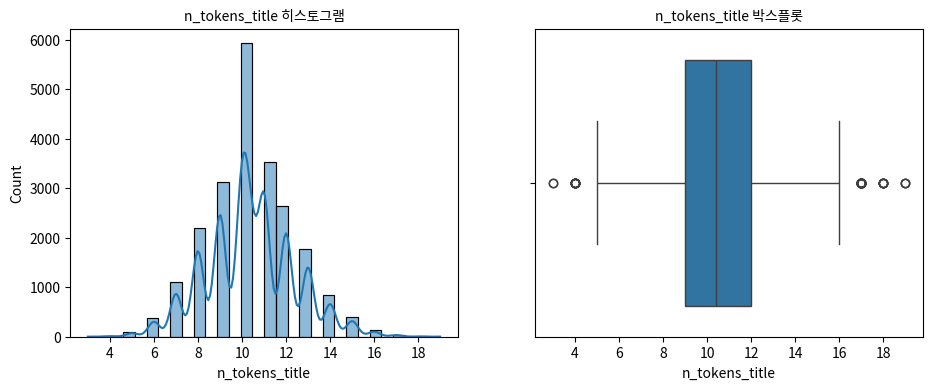

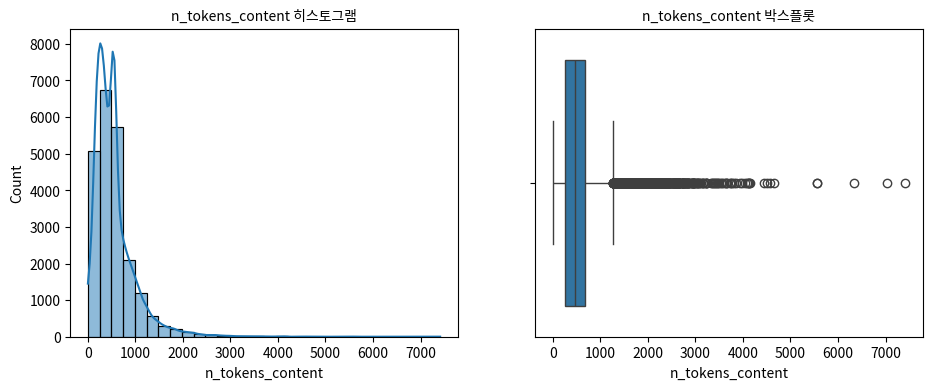

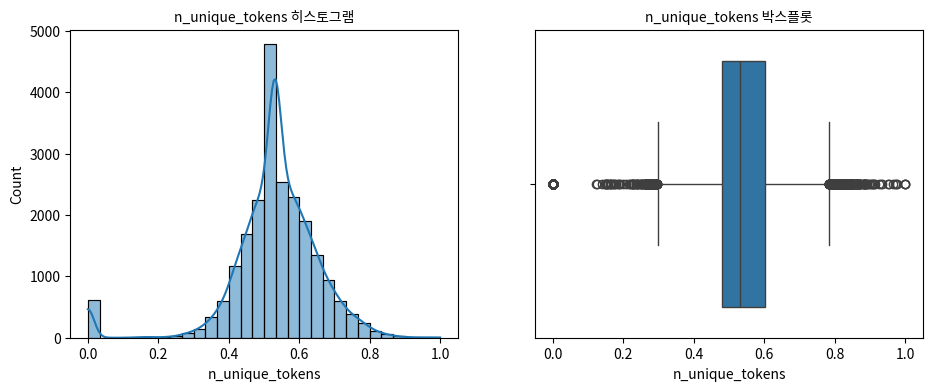

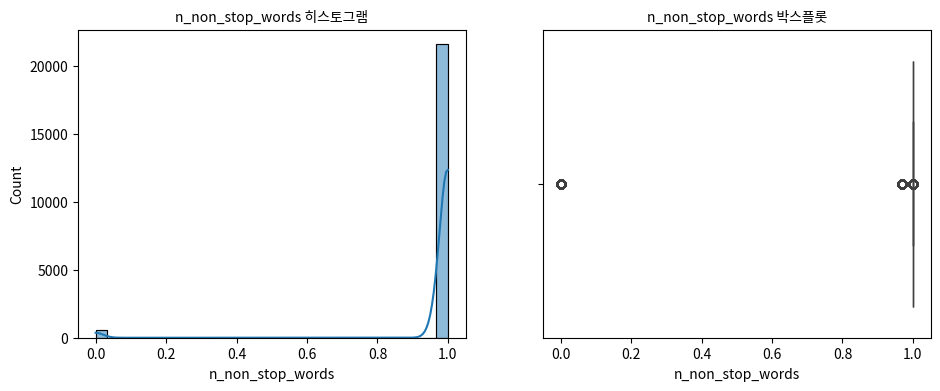

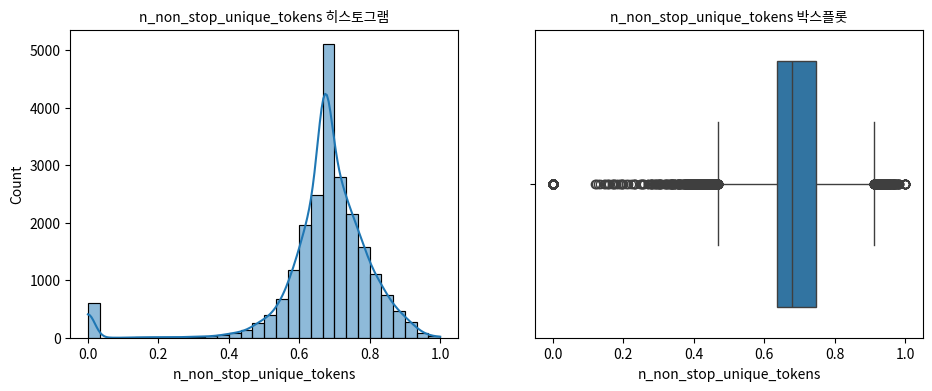

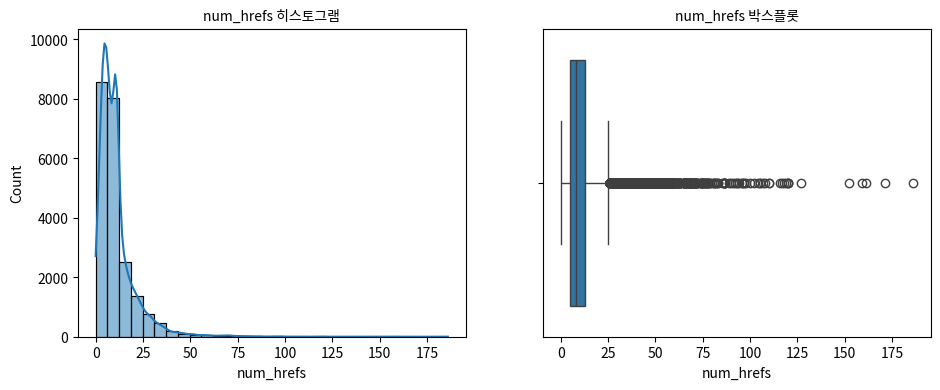

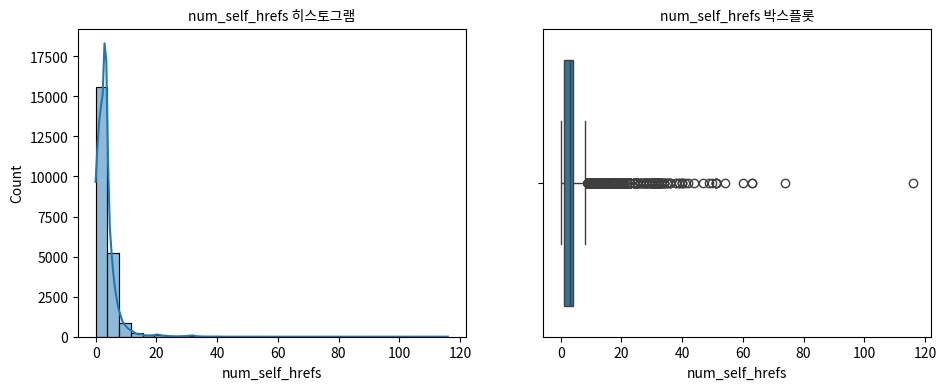

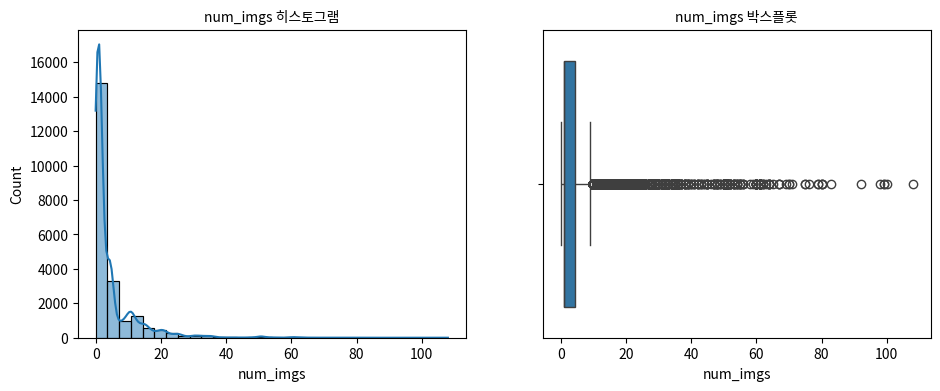

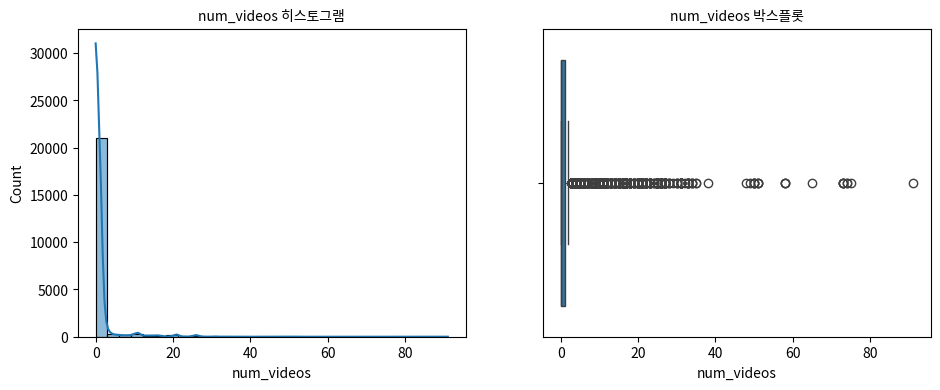

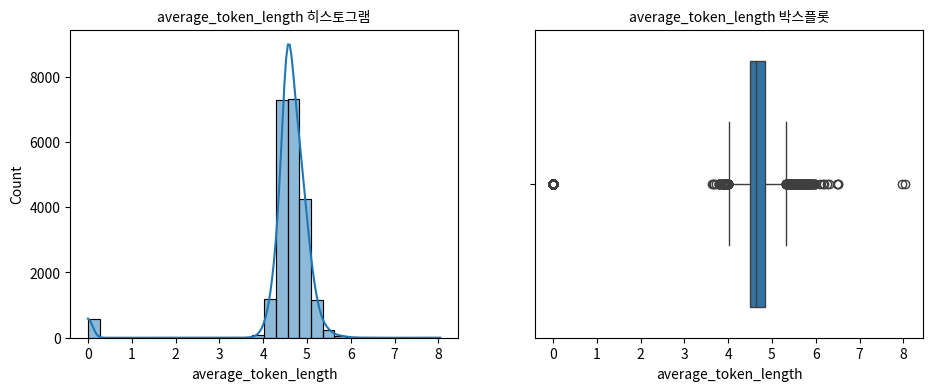

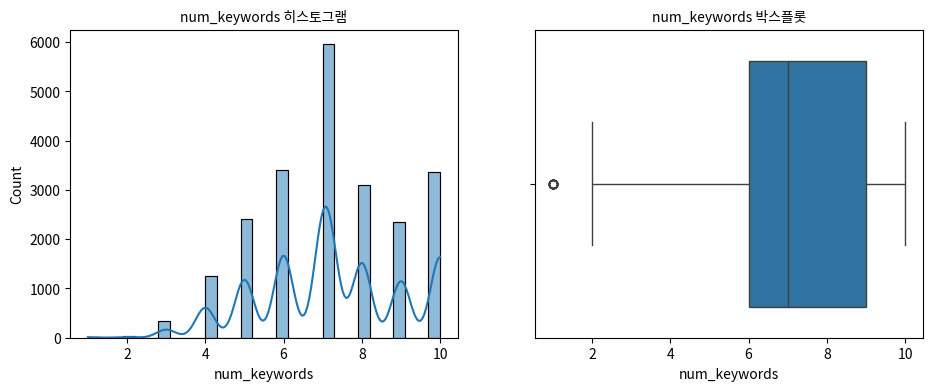

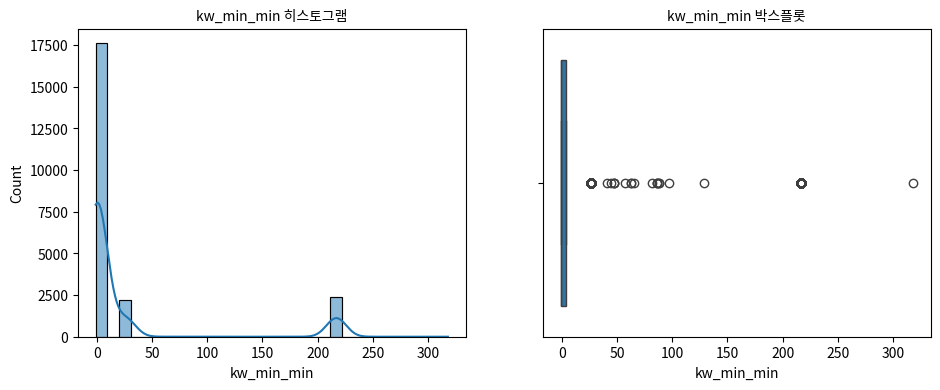

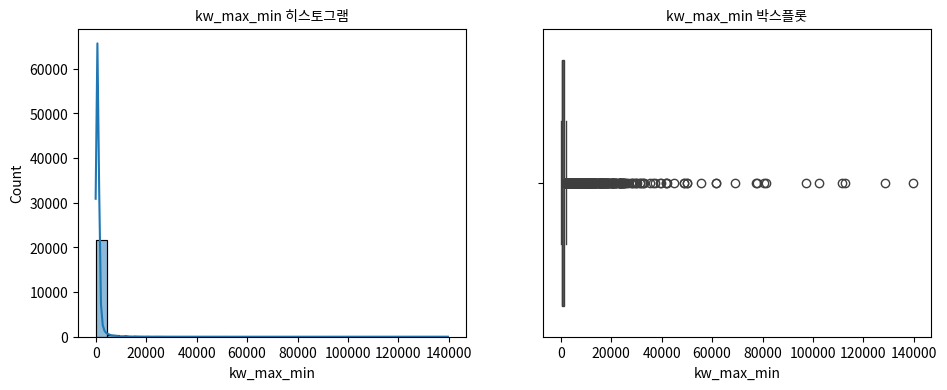

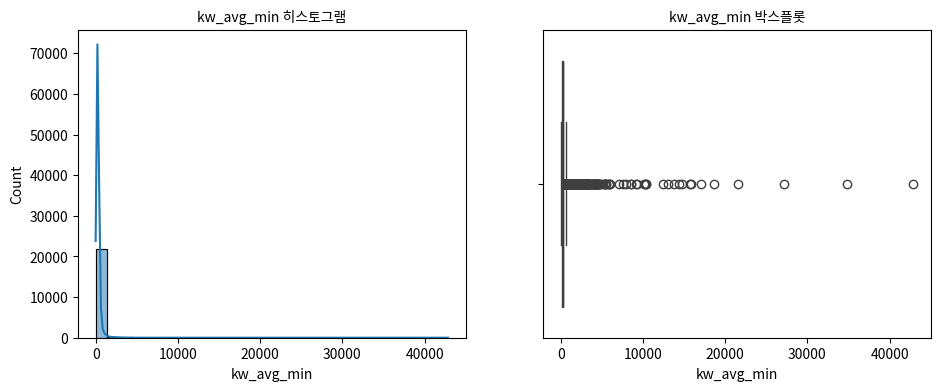

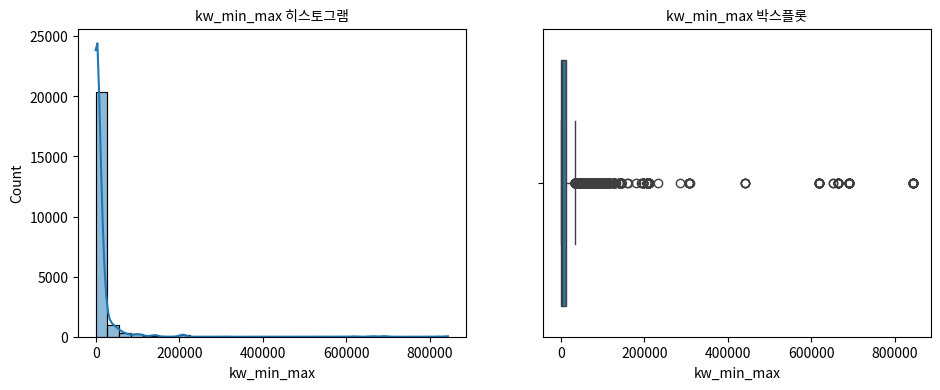

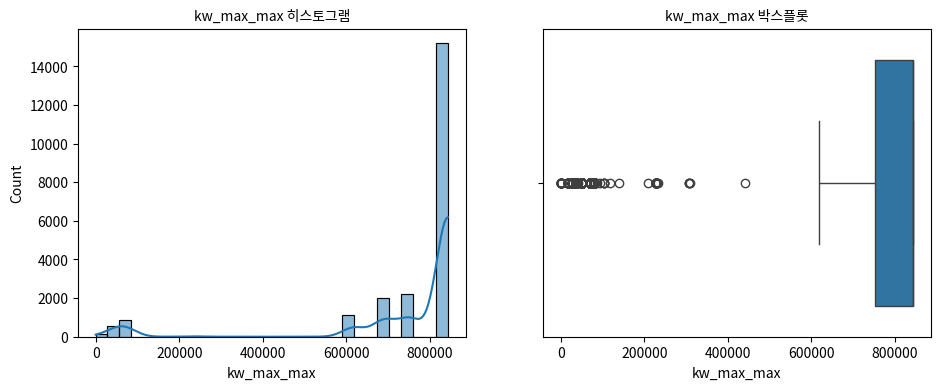

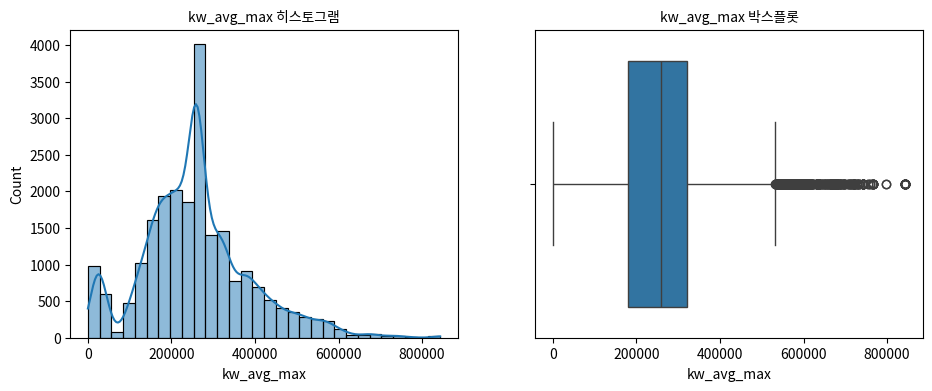

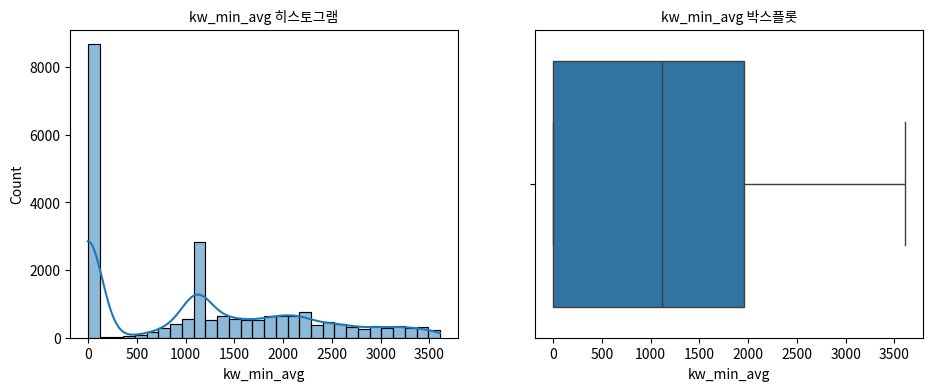

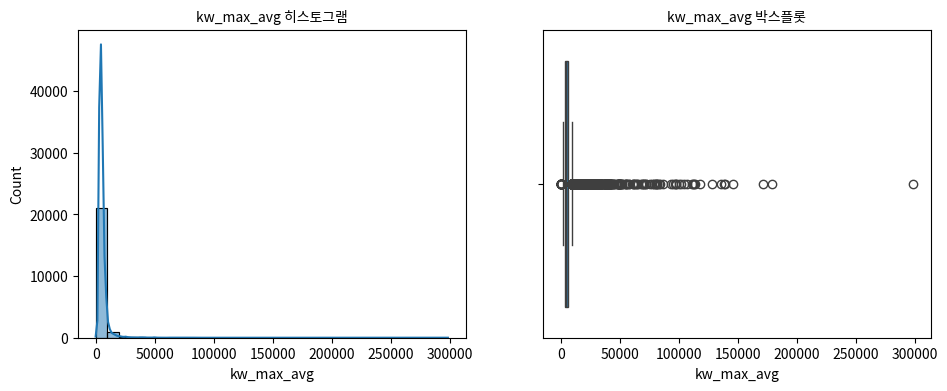

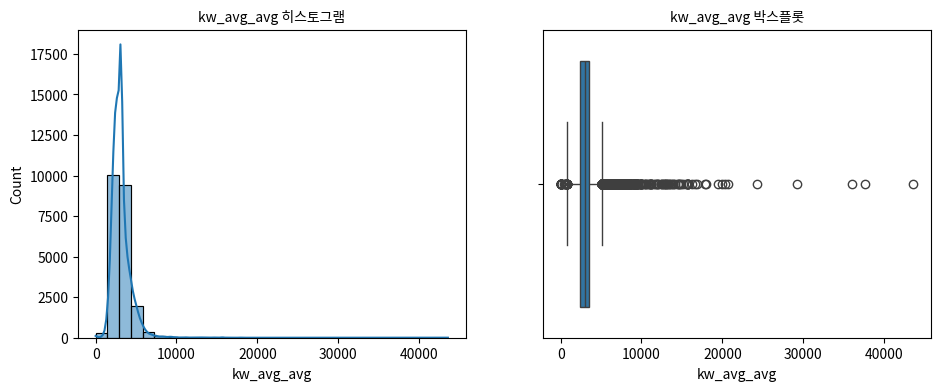

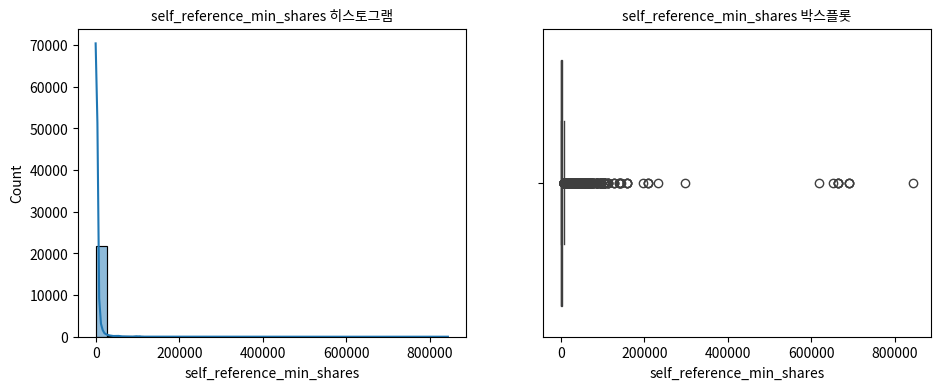

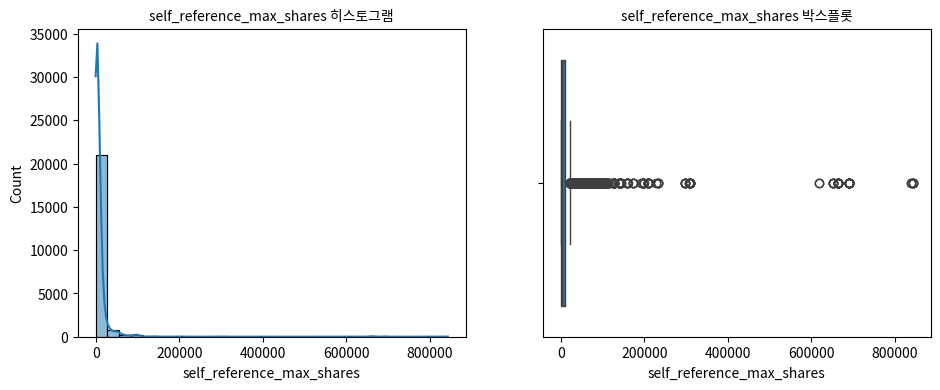

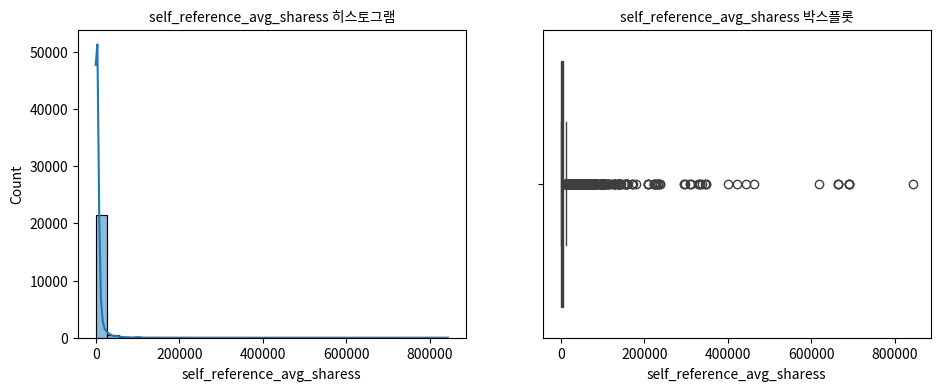

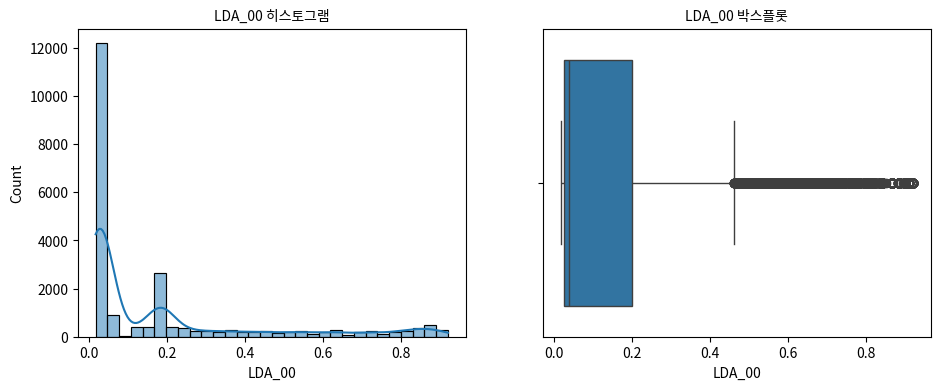

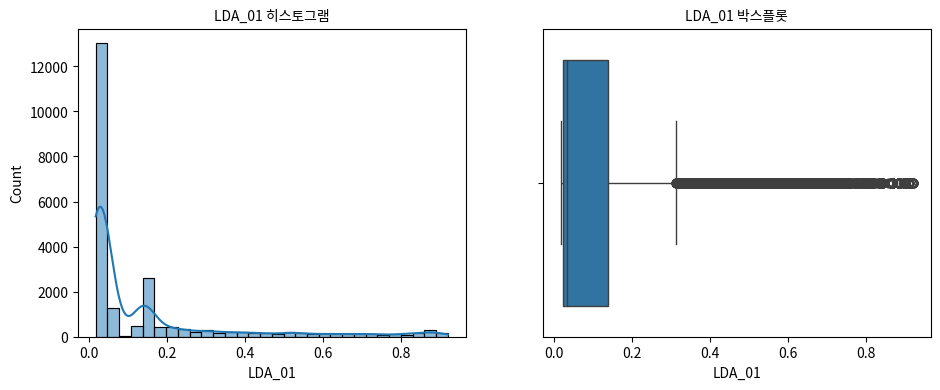

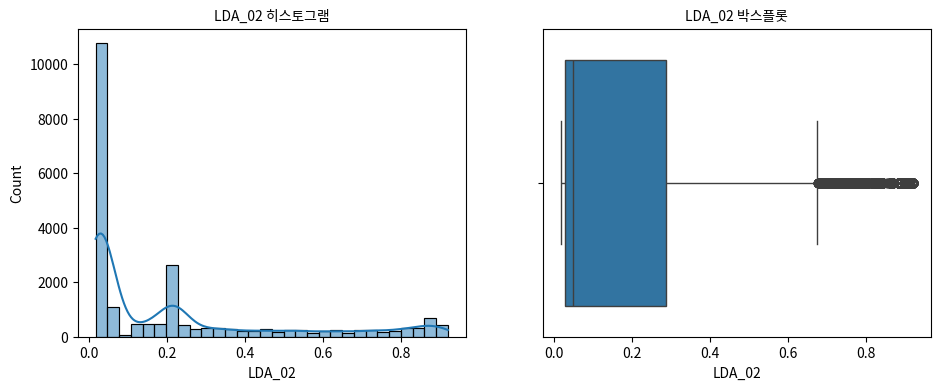

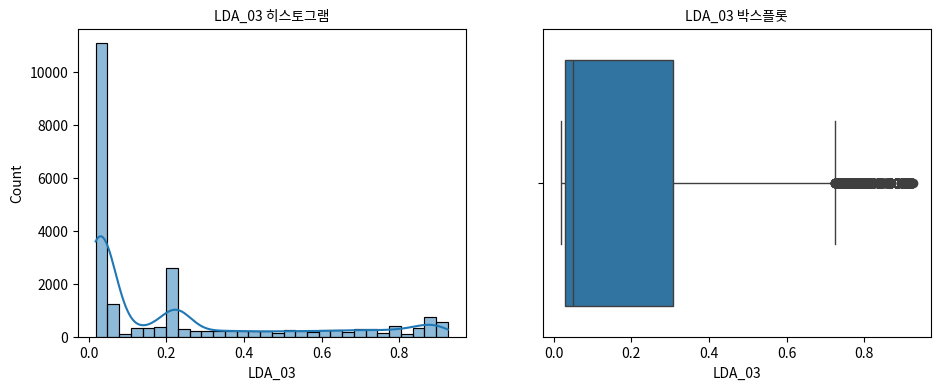

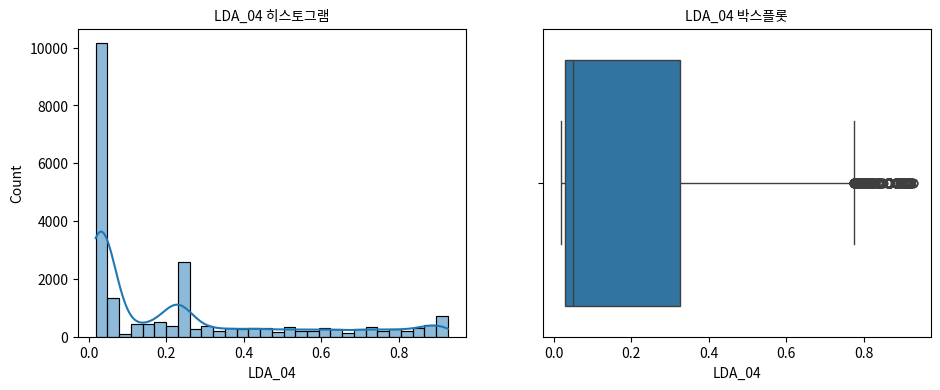

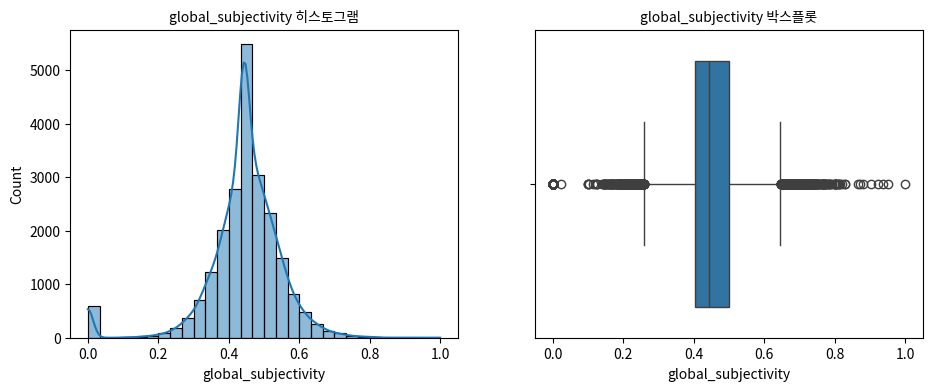

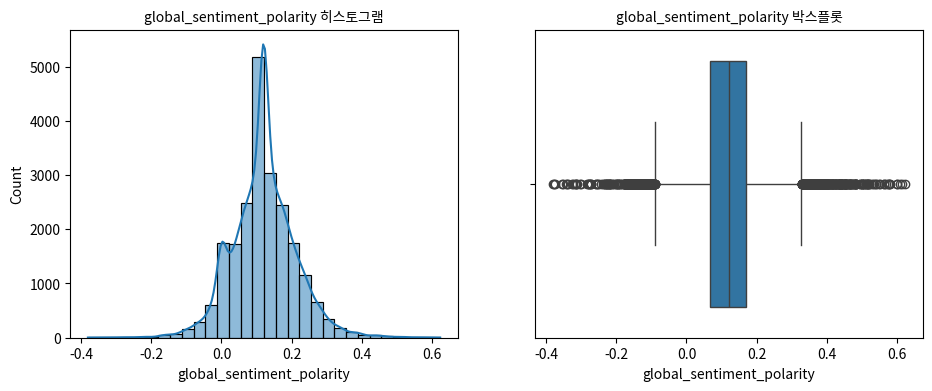

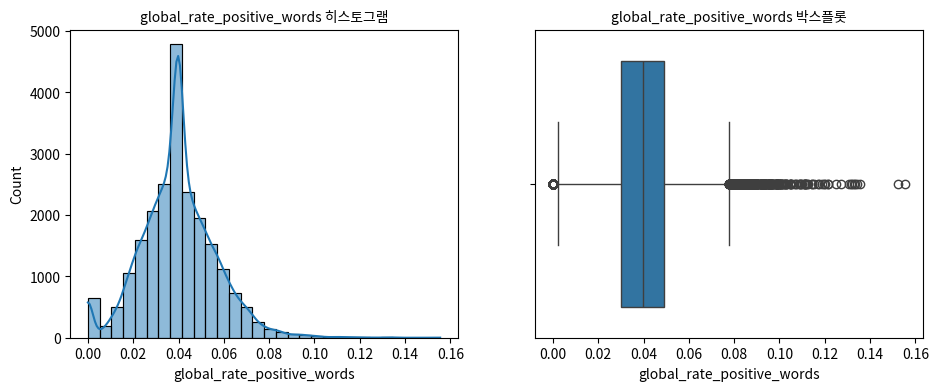

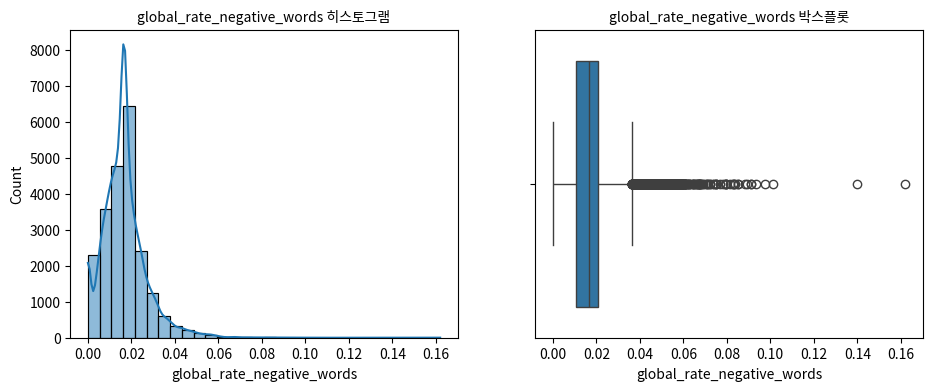

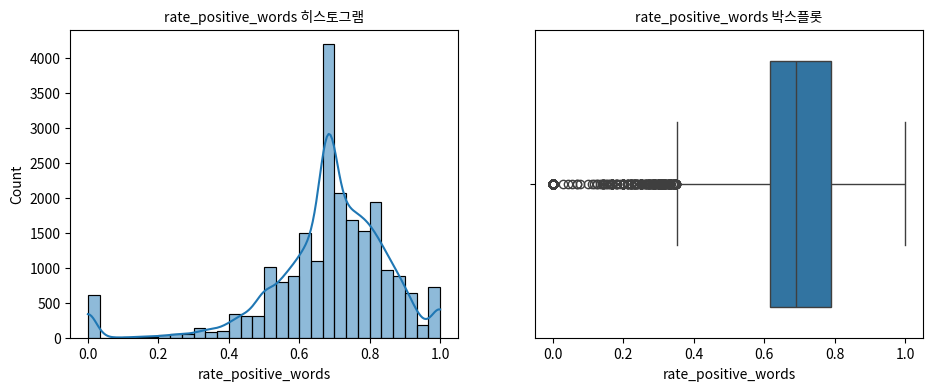

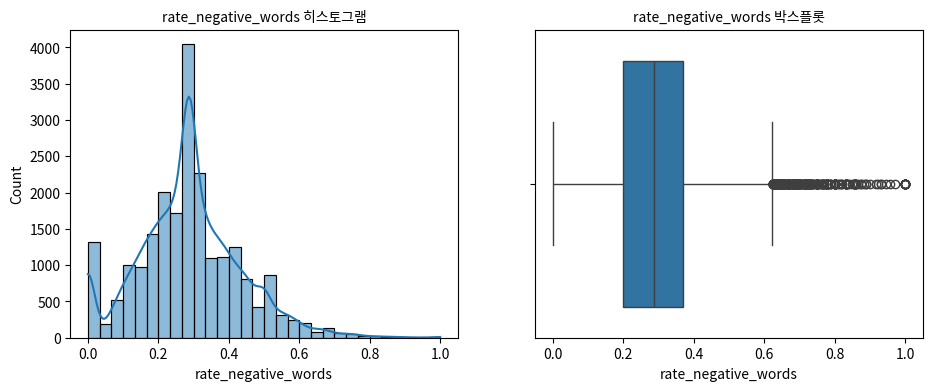

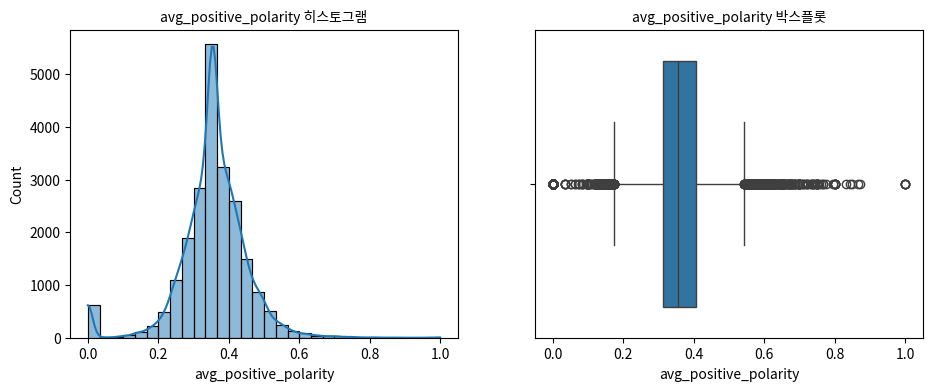

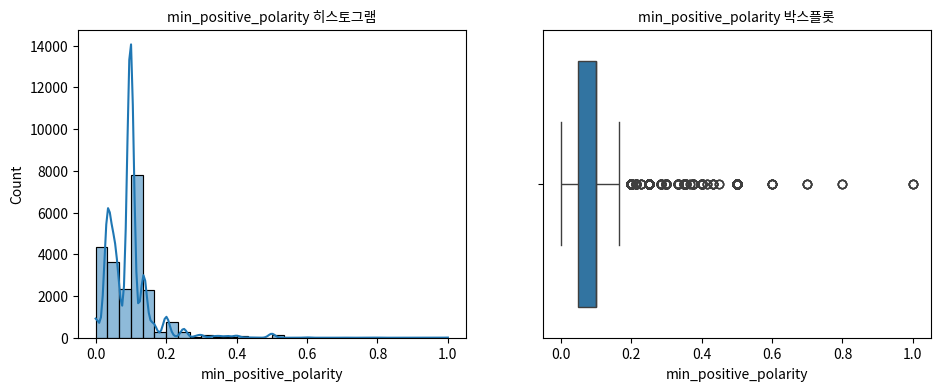

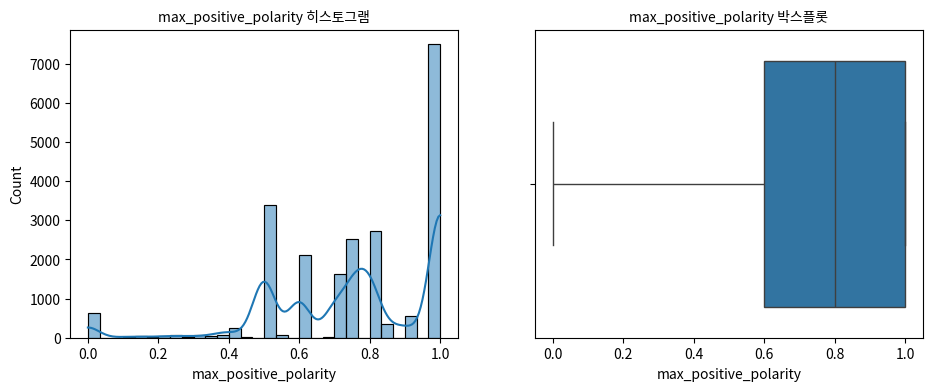

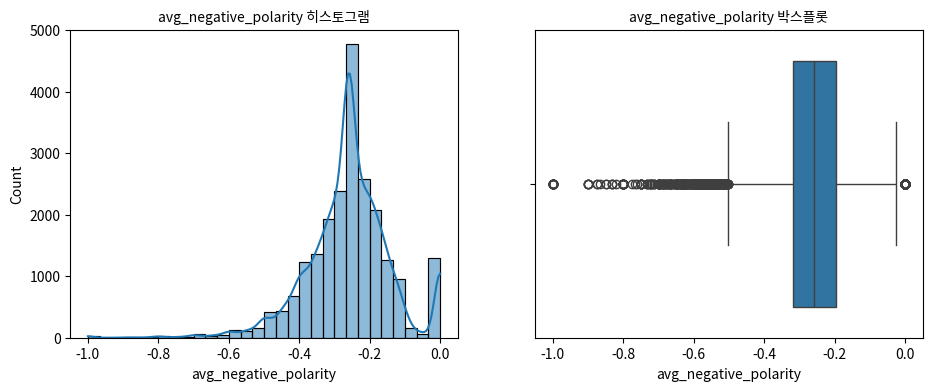

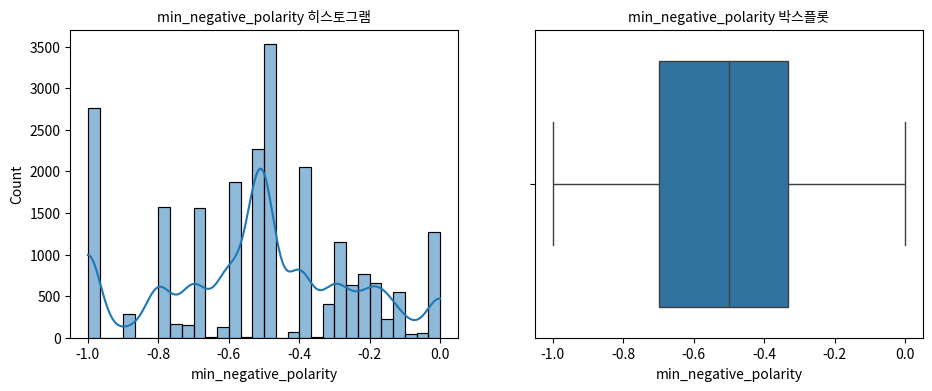

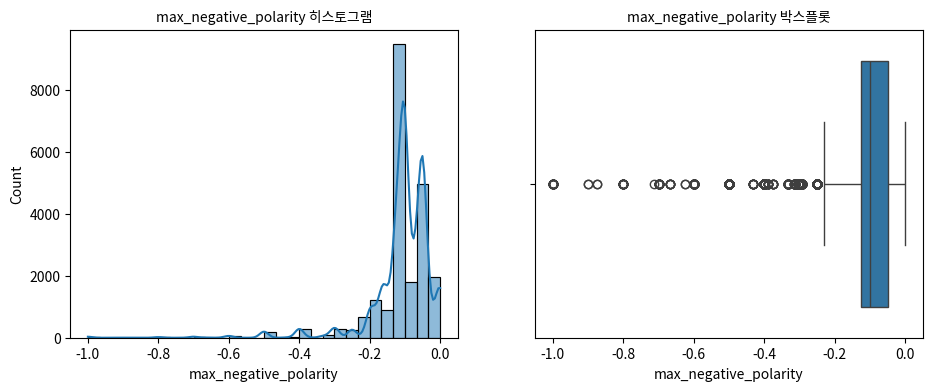

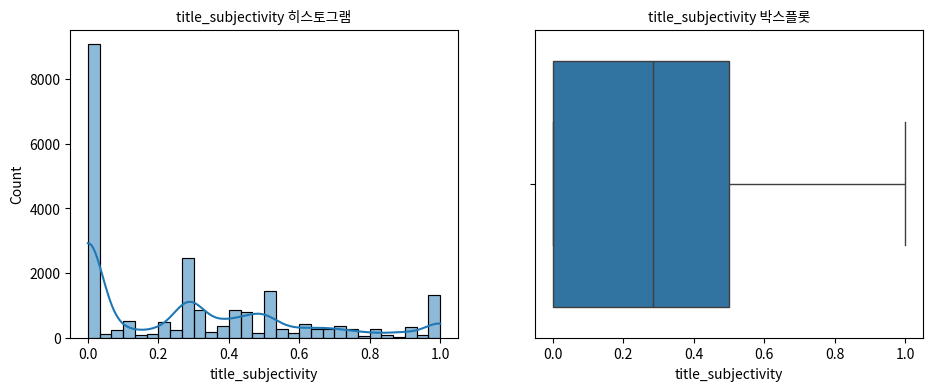

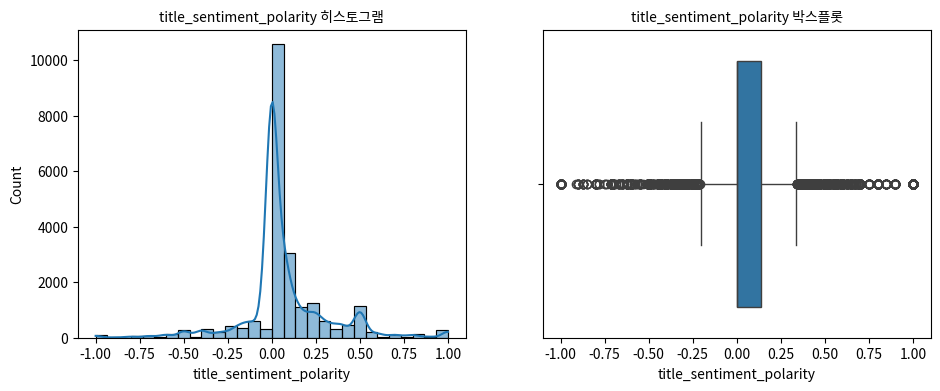

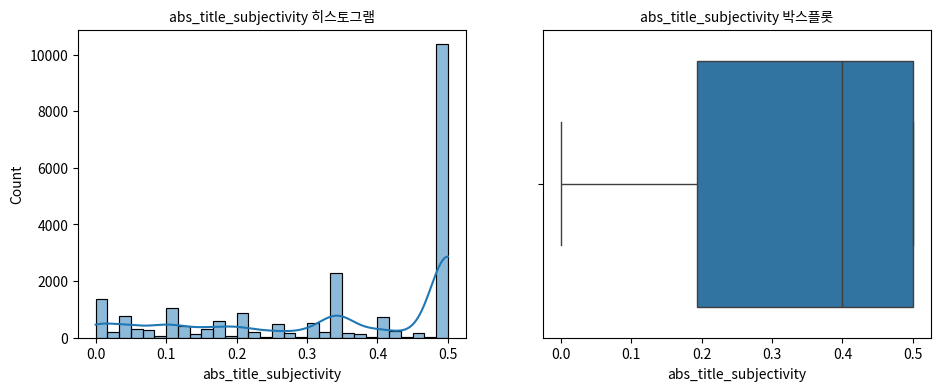

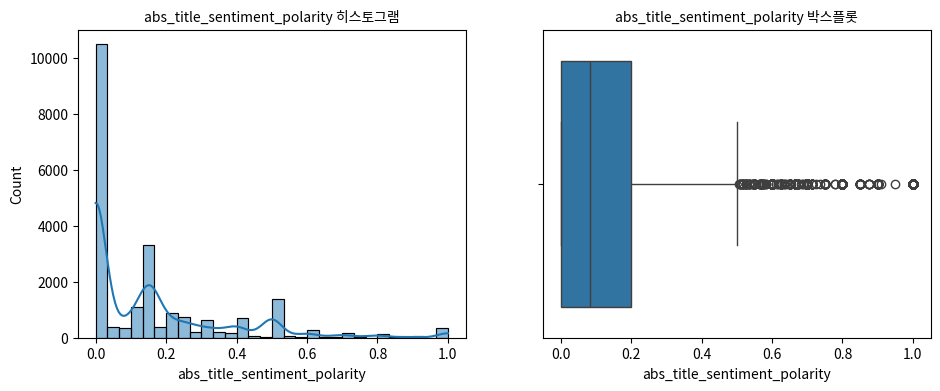

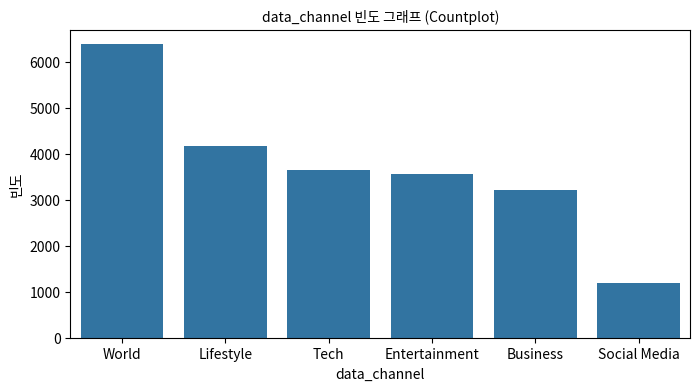

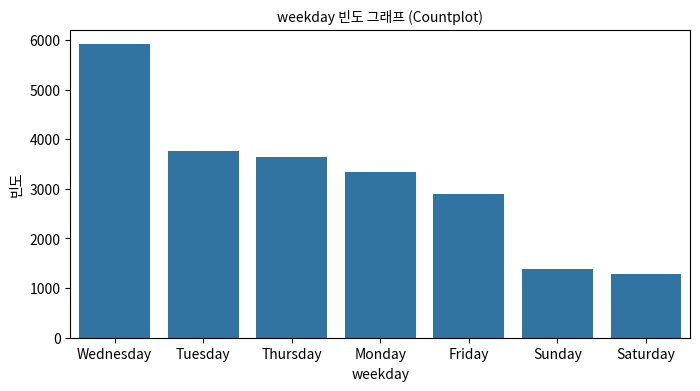

In [22]:
# 단일 변수 분포 탐색
for col in num_cols:
    plt.figure(figsize=(11,4))
    plt.subplot(1,2,1)
    sns.histplot(X[col], bins=30, kde=True)
    plt.title(f'{col} 히스토그램', fontproperties=fontprop)

    plt.subplot(1,2,2)
    sns.boxplot(x=X[col])
    plt.title(f'{col} 박스플롯', fontproperties=fontprop)
    plt.show()


for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=X[col], order=X[col].value_counts().index)
    plt.title(f'{col} 빈도 그래프 (Countplot)', fontproperties=fontprop)
    plt.xlabel(col)
    plt.ylabel('빈도', fontproperties=fontprop)
    plt.show()

In [23]:
# 이상치 개수 및 비율 계산 (IQR 방식)
outlier_counts = {}
for col in num_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    mask = (X[col] < lower) | (X[col] > upper)
    outlier_counts[col] = mask.sum()

out_df = pd.Series(outlier_counts, name='이상치 개수').sort_values(ascending=False).to_frame()
out_df['이상치 비율(%)'] = out_df['이상치 개수'] / len(X) * 100
out_df = out_df.sort_values('이상치 비율(%)', ascending=False)
out_df

,이상치 개수,이상치 비율(%)
kw_min_min,4601,20.725225
title_sentiment_polarity,4094,18.441441
num_imgs,3528,15.891892
LDA_00,3342,15.054054
n_non_stop_words,3091,13.923423
LDA_01,3082,13.882883
LDA_02,2626,11.828829
LDA_03,2512,11.315315
avg_negative_polarity,1878,8.459459
LDA_04,1861,8.382883


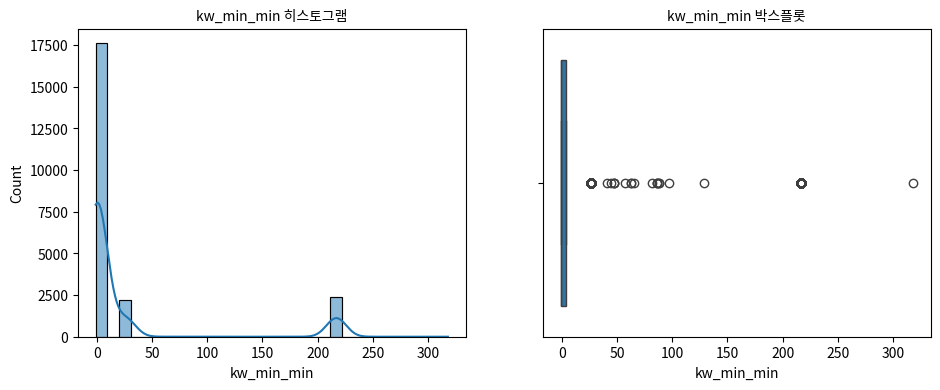

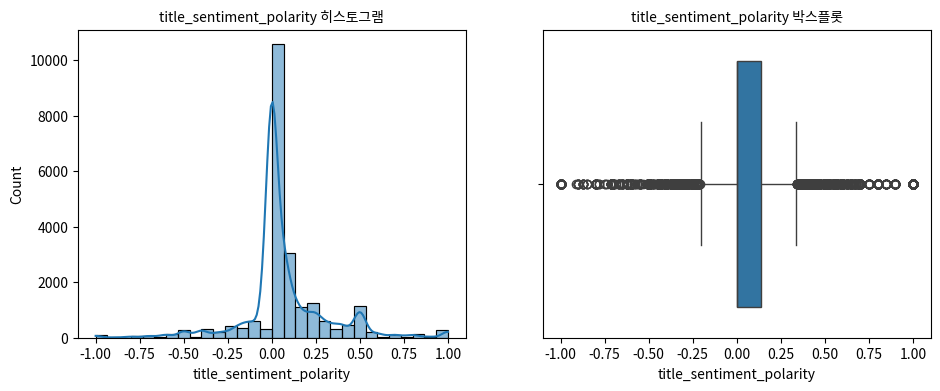

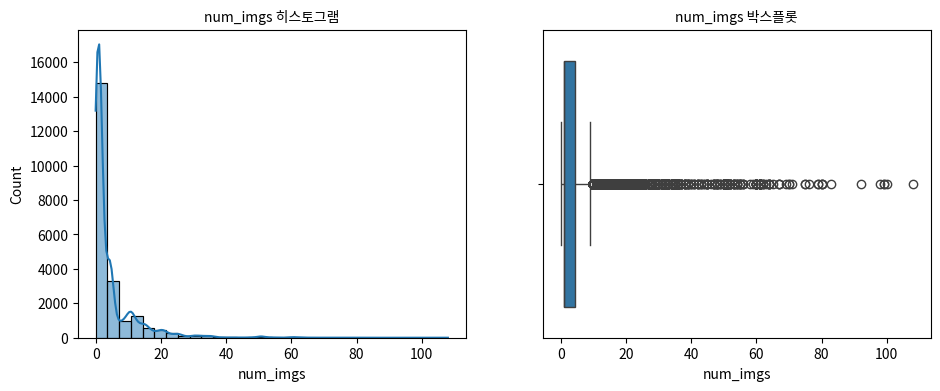

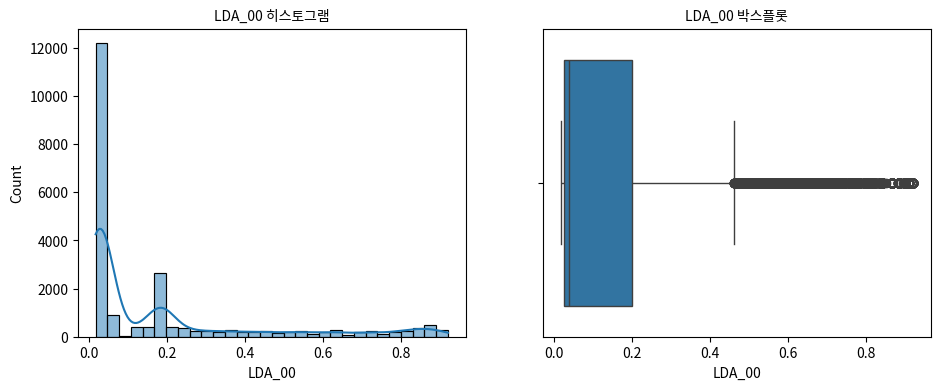

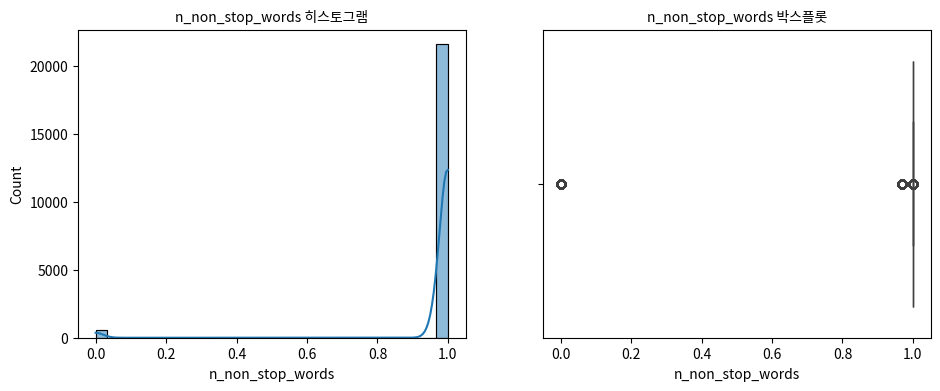

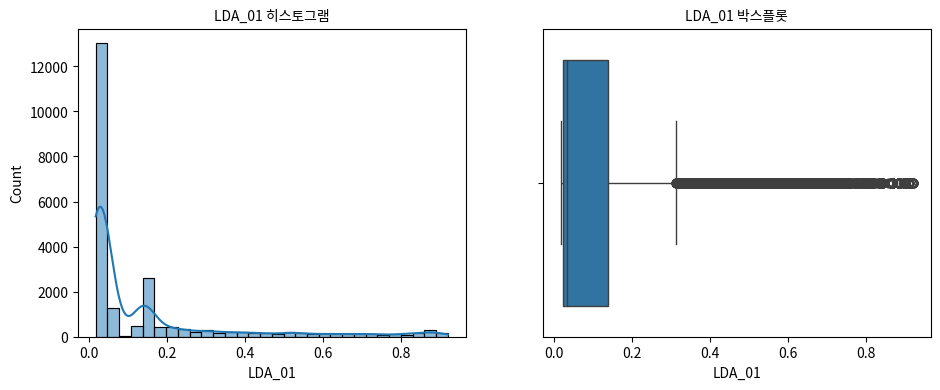

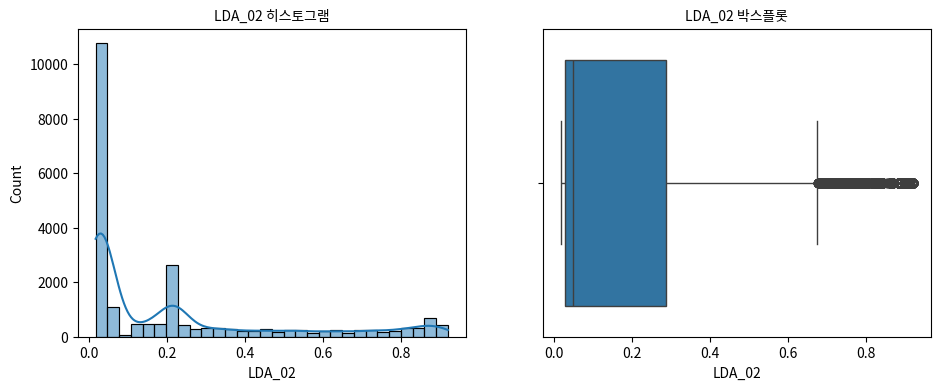

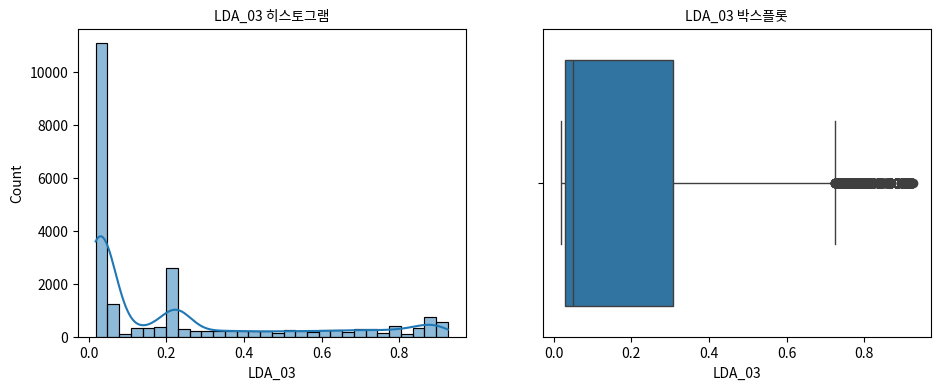

In [24]:
# 이상치 비율 상위 8개 변수 재시각화
top8 = out_df.head(8).index.tolist()
for col in top8:
    plt.figure(figsize=(11,4))
    plt.subplot(1,2,1)
    sns.histplot(X[col], bins=30, kde=True)
    plt.title(f'{col} 히스토그램', fontproperties=fontprop)
    plt.subplot(1,2,2)
    sns.boxplot(x=X[col])
    plt.title(f'{col} 박스플롯', fontproperties=fontprop)
    plt.show()

## 이상치 비율 상위 8개 변수 재시각화 분석
이상치 비율이 10% 이상인 상위 8개의 변수를 재시각화하였습니다.

처리 기법:
- 로그 변환
- Winsorizing

Skewness(왜도) 계산 후
- skew > 1.0 (극단적인 꼬리): 로그 변환
- swew 0.5~1.0 (적당한 꼬리, 소량의 이상치): Winsorizing
- skew 음수 값 포함(±범위): Winsorizing

EDA 단계에서는 로그 변환/Winsorizing 시도하여 분포가 어떻게 변하는지만 시각화하였습니다.

최종적으로 어떤 변환을 적용할지 결정하고 제거, 교체하는 단계는 이후 피처 엔지니어링 단계에서 진행합니다.


In [25]:
# top8 로그 변환 및 Winsorizing
X_log = pd.DataFrame(index=X.index)
X_cap = pd.DataFrame(index=X.index)

for col in top8:
    # 로그 변환
    # - 양수 변수: log1p
    # - 음수 포함 변수: shift → log1p
    if X[col].min() >= 0:
        X_log[f'{col}_log'] = np.log1p(X[col])
    else:
        shift = -X[col].min() + 1e-6  # 최소값을 0 이상으로 올리기 위한 shift
        X_log[f'{col}_log'] = np.log1p(X[col] + shift)
    # Winsorizing (상·하위 1% 컷)
    capped = winsorize(X[col], limits=(0.01, 0.01)).data
    X_cap[col] = pd.Series(capped, index=X.index)

X_cap

,kw_min_min,title_sentiment_polarity,num_imgs,LDA_00,n_non_stop_words,LDA_01,LDA_02,LDA_03
0,217.0,0.500000,11.000000,0.139798,1.000000,0.020023,0.020008,0.020092
1,217.0,0.000000,4.473431,0.028627,1.000000,0.028671,0.320833,0.593291
2,-1.0,0.125000,1.000000,0.028573,1.000000,0.028573,0.885708,0.028573
3,-1.0,0.070169,4.473431,0.025806,0.970175,0.025004,0.187663,0.436807
4,-1.0,0.000000,4.473431,0.524843,1.000000,0.025733,0.149361,0.025220
...,...,...,...,...,...,...,...,...
22195,-1.0,0.000000,1.000000,0.022224,1.000000,0.022549,0.266434,0.666563
22196,4.0,0.000000,4.473431,0.034357,1.000000,0.033676,0.218162,0.035036
22197,4.0,0.000000,1.000000,0.486985,1.000000,0.437312,0.025092,0.025395
22198,-1.0,0.000000,1.000000,0.366135,1.000000,0.033334,0.533862,0.225225


In [26]:
print("원본 X shape:", X.shape)
print("X_log shape:",  X_log.shape)
print("X_cap shape:",  X_cap.shape)


원본 X shape: (22200, 46)
X_log shape: (22200, 8)
X_cap shape: (22200, 8)


## 데이터 분석

- 변수들 사이의 관계 분석, 인과관계의 확인, 많은 변수와 유사성을 확인 → 정보를 효과적으로 추출
1. 변수들간의 관계 확인법
    1. 상관분석
    2. 교차분석
    3. 분산분석 (ANOVA / MANOVA)
    4. 회귀모델 (다중 선형회귀 / 로지스틱 회귀)
2. 차원축소법
    1. PCA (주성분분석)
    2. FA (요인분석)
    3. CCA(정준상관분석)
    
    +) t-SNE, UMAP
    
3. 개체 분류법
    1. 판별분석 (LDA 선형판별분석/ QDA 이차판별분석)
    2. 로지스틱 회귀분석
    3. 군집분석 (K-Means, Hierarchical)
    4. MDS(다차원척도법)

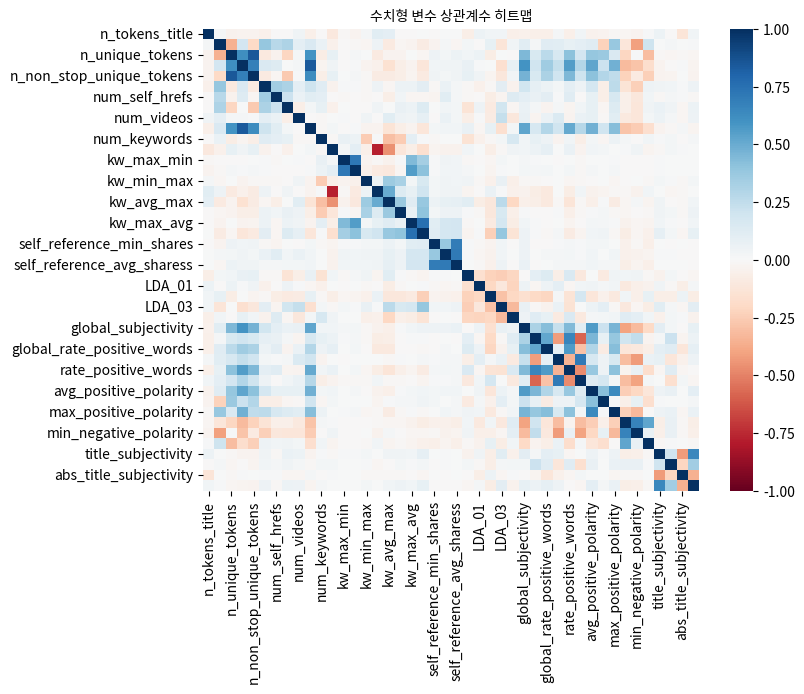

'\nn_non_stop_unique_tokens 등은 0.8 이상의 매우 높은 상관\n→ 본문 단어 수가 많아질수록 “불용어 제외 단어 수”도 당연히 함께 늘어남\n\nself_reference_min_shares, self_reference_max_shares, self_reference_avg_shares 간에 0.9 이상\n→ 참조된 다른 기사들의 공유량(최소·최대·평균)이 거의 동일한 경향성\n\nrate_positive_words ↔ rate_negative_words\n→ 본문에서 긍정 비율이 높으면 부정 비율은 낮아지는 단순한 반비례 관계\n\ny(바이럴 여부)와 모든 수치형 피처 간 상관계수는 –0.05~0.05 사이로 매우 낮음\n→ 선형적인(직선적인) 관계로는 “바이럴 여부”를 잘 설명하기 어렵다는 뜻\n\n(1) 다중공선성 주의\n→ 상관계수가 0.8 이상인 피처들은 하나로 묶거나, PCA/차원 축소, 혹은 불필요한 피처 제거 고려\n\n(2) 타과의 비선형 관계 탐색\n→ y와 선형 상관이 낮으니, Mutual Information, Tree-based Importance, SHAP 같은 기법으로\n비선형·상호작용 관계를 살펴보기\n\n(3) 모델링시 피처 선택\n초기에 상관이 낮은 피처 위주(예: LDA 토픽 점수, metadata)로 시도해 보고,\n성능에 따라 군집화된 피처 중 대표 하나만 선택해 추가\n'

In [27]:
# 상관계수 매트릭스 & 히트맵

corr = X[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr,
            annot=False,
            cmap='RdBu',
            vmin=-1, vmax=1,
            center=0,
            fmt=".2f")
plt.title("수치형 변수 상관계수 히트맵", fontproperties=fontprop)
plt.show()

'''
n_non_stop_unique_tokens 등은 0.8 이상의 매우 높은 상관
→ 본문 단어 수가 많아질수록 “불용어 제외 단어 수”도 당연히 함께 늘어남

self_reference_min_shares, self_reference_max_shares, self_reference_avg_shares 간에 0.9 이상
→ 참조된 다른 기사들의 공유량(최소·최대·평균)이 거의 동일한 경향성

rate_positive_words ↔ rate_negative_words
→ 본문에서 긍정 비율이 높으면 부정 비율은 낮아지는 단순한 반비례 관계

y(바이럴 여부)와 모든 수치형 피처 간 상관계수는 –0.05~0.05 사이로 매우 낮음
→ 선형적인(직선적인) 관계로는 “바이럴 여부”를 잘 설명하기 어렵다는 뜻

(1) 다중공선성 주의
→ 상관계수가 0.8 이상인 피처들은 하나로 묶거나, PCA/차원 축소, 혹은 불필요한 피처 제거 고려

(2) 타과의 비선형 관계 탐색
→ y와 선형 상관이 낮으니, Mutual Information, Tree-based Importance, SHAP 같은 기법으로
비선형·상호작용 관계를 살펴보기

(3) 모델링시 피처 선택
초기에 상관이 낮은 피처 위주(예: LDA 토픽 점수, metadata)로 시도해 보고,
성능에 따라 군집화된 피처 중 대표 하나만 선택해 추가
'''

# 그룹별 분석

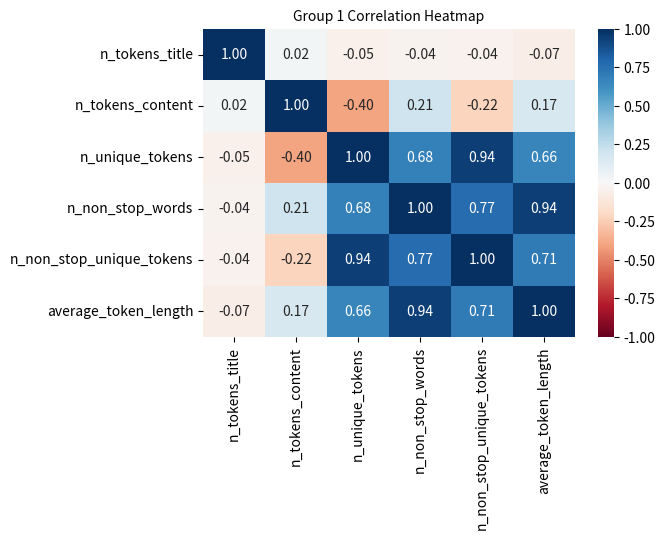

In [32]:
# 1. 기초 텍스트 통계
g1_cols = [
    'n_tokens_title',
    'n_tokens_content',
    'n_unique_tokens',
    'n_non_stop_words',
    'n_non_stop_unique_tokens',
    'average_token_length'
]

corr_g1 = df[g1_cols].corr()


plt.figure(figsize=(6,4))
sns.heatmap(corr_g1,
            annot=True,
            cmap='RdBu',
            vmin=-1, vmax=1, center=0,
            fmt=".2f")
plt.title("Group 1 Correlation Heatmap", fontproperties=fontprop)
plt.show()



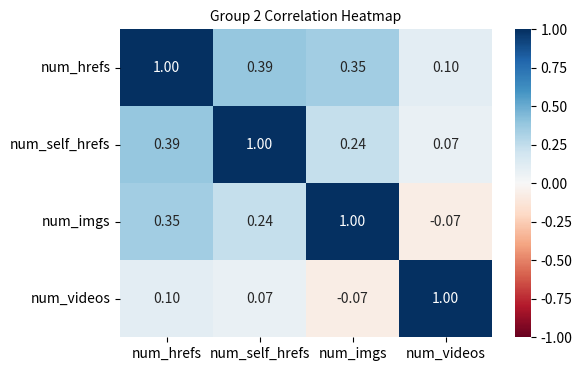

In [36]:
# 2. 하이퍼링크&미디어 개수
g2_cols = [
    'num_hrefs', 'num_self_hrefs',
    'num_imgs', 'num_videos'
]


corr_g2 = df[g2_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_g2,
            annot=True,
            cmap='RdBu',
            vmin=-1, vmax=1, center=0,
            fmt=".2f")
plt.title("Group 2 Correlation Heatmap", fontproperties=fontprop)
plt.show()


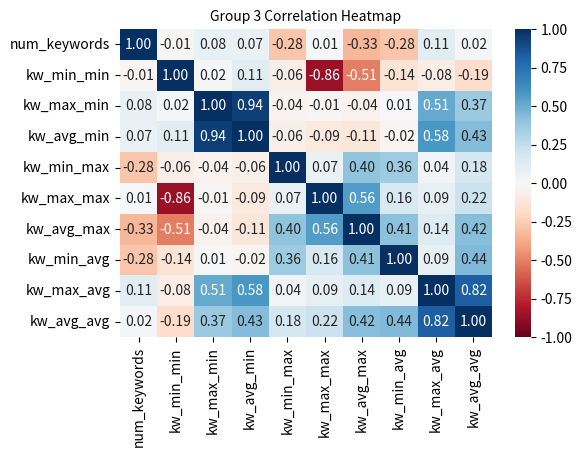

In [40]:
# 3. 키워드 통계 (키워드 수 & 위치 정보)
g3_cols = [
    'num_keywords',
    'kw_min_min', 'kw_max_min', 'kw_avg_min',
    'kw_min_max', 'kw_max_max', 'kw_avg_max',
    'kw_min_avg', 'kw_max_avg', 'kw_avg_avg'
]

corr_g3 = df[g3_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_g3,
            annot=True,
            cmap='RdBu',
            vmin=-1, vmax=1, center=0,
            fmt=".2f")
plt.title("Group 3 Correlation Heatmap", fontproperties=fontprop)
plt.show()

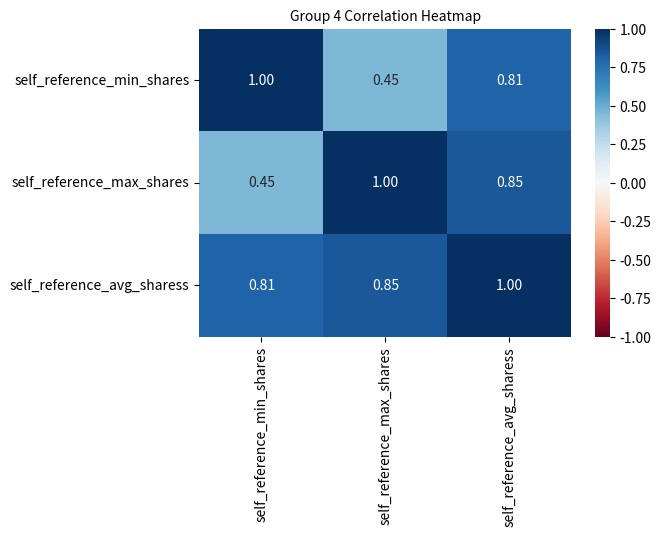

In [41]:
# 4. 자체 인용 공유 횟수
g4_cols = [
    'self_reference_min_shares',
    'self_reference_max_shares',
    'self_reference_avg_sharess' ## 오타 수정?
]

corr_g4 = df[g4_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_g4,
            annot=True,
            cmap='RdBu',
            vmin=-1, vmax=1, center=0,
            fmt=".2f")
plt.title("Group 4 Correlation Heatmap", fontproperties=fontprop)
plt.show()

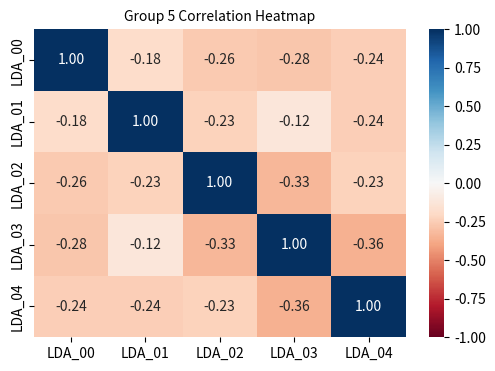

In [44]:
# 5. 토픽별 모델링 출력
g5_cols = ['LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04']

corr_g5 = df[g5_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_g5,
            annot=True,
            cmap='RdBu',
            vmin=-1, vmax=1, center=0,
            fmt=".2f")
plt.title("Group 5 Correlation Heatmap", fontproperties=fontprop)
plt.show()

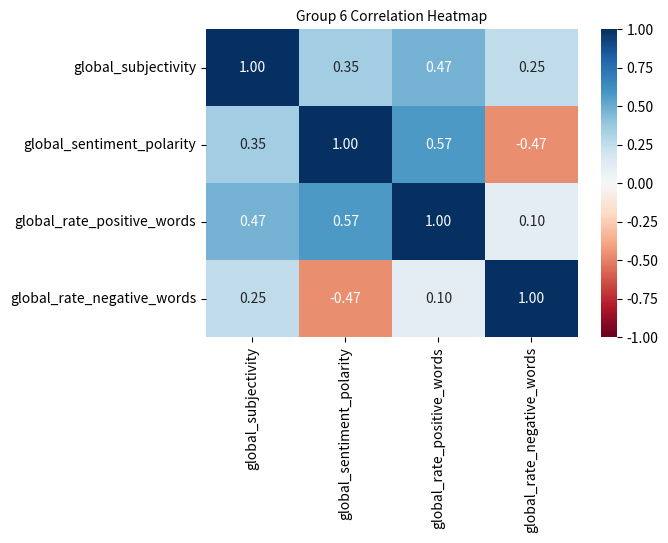

In [45]:
# 6. 글로벌 감성 지표
g6_cols = [
    'global_subjectivity',
    'global_sentiment_polarity',
    'global_rate_positive_words',
    'global_rate_negative_words'
]

corr_g6 = df[g6_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_g6,
            annot=True,
            cmap='RdBu',
            vmin=-1, vmax=1, center=0,
            fmt=".2f")
plt.title("Group 6 Correlation Heatmap", fontproperties=fontprop)
plt.show()

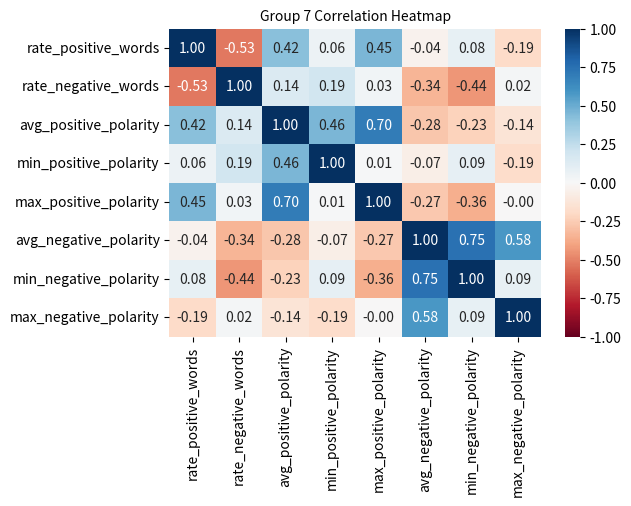

In [46]:
# 7. 본문(내용) 감성 지표
g7_cols = [
    'rate_positive_words', 'rate_negative_words',
    'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity',
    'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity'
]

corr_g7 = df[g7_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_g7,
            annot=True,
            cmap='RdBu',
            vmin=-1, vmax=1, center=0,
            fmt=".2f")
plt.title("Group 7 Correlation Heatmap", fontproperties=fontprop)
plt.show()

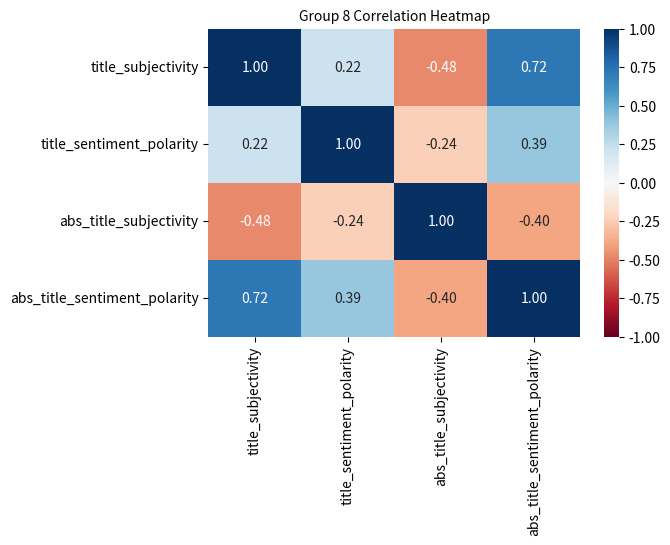

In [48]:
# 8. 감성 지표 분석
g8_cols = [
    'title_subjectivity',
    'title_sentiment_polarity',
    'abs_title_subjectivity',
    'abs_title_sentiment_polarity'
]

corr_g8 = df[g8_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_g8,
            annot=True,
            cmap='RdBu',
            vmin=-1, vmax=1, center=0,
            fmt=".2f")
plt.title("Group 8 Correlation Heatmap", fontproperties=fontprop)
plt.show()